# Выбор локации для скважины

## Описание проекта

Проект для добывающей компании «ГлавРосГосНефть». Необходимо решить, где бурить новую скважину.

Предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Построим модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируем возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков(качество нефти и объём её запасов);
- Строят модель для предсказания объёма запасов в новых скважинах;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

Характеристики для каждой скважины в регионе уже известны. 

План выполнения проекта:

1. Загрузим и подготовим данные. Поясним порядок действий.
2. Обучим и проверим модель для каждого региона:
    1. Разобьём данные на обучающую и валидационную выборки в соотношении 75:25.
    2. Обучим модель и сделаем предсказания на валидационной выборке.
    3. Сохраним предсказания и правильные ответы на валидационной выборке.
    4. Распечатаем средний запас предсказанного сырья и RMSE модели.
    5. Проанализируем результаты.
3. Подготовимся к расчёту прибыли:
    1. Все ключевые значения для расчётов сохраним в отдельных переменных.
    2. Рассчитаем достаточный объём сырья для безубыточной разработки новой скважины. Сравним полученный объём сырья со средним запасом в каждом регионе.
    3. Сделаем выводы по этапу подготовки расчёта прибыли.
4. Напишем функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели:
    1. Выберем скважины с максимальными значениями предсказаний.
    2. Просуммируем целевое значение объёма сырья, соответствующее этим предсказаниям.
    3. Рассчитаем прибыль для полученного объёма сырья.
5. Посчитаем риски и прибыль для каждого региона:
    1. Применим технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли.
    2. Найдём среднюю прибыль, 95%-й доверительный интервал и риск убытков.
    3. Сделаем выводы: предложим регион для разработки скважин и обоснуйте выбор.

Данные геологоразведки трёх регионов находятся в файлах:
- `/datasets/geo_data_0.csv`
- `/datasets/geo_data_1.csv`
- `/datasets/geo_data_2.csv`

Описание данных:

- `id` — уникальный идентификатор скважины;
- `f0`, `f1`, `f2` — три признака точек (неважно, что они означают, но сами признаки значимы);
- `product` — объём запасов в скважине (тыс. баррелей).

Условия задачи:

- Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
- При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
- Бюджет на разработку скважин в регионе — 10 млрд рублей.
- При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
- После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.
- Данные синтетические: детали контрактов и характеристики месторождений не разглашаются.

## Загрузка и подготовка данных

### Загрузка библиотек и данных

In [11]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import os.path
import math

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from scipy import stats as st

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.options.mode.chained_assignment = None

plt.style.use('dark_background')

In [12]:
try:
    path_0 = os.path.join('datasets/geo_data_0.csv')
    data_0 = pd.read_csv(path_0)
except:
    data_0 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_0.csv')

try:
    path_1 = os.path.join('datasets/geo_data_1.csv')
    data_1 = pd.read_csv(path_1)
except:
    data_1 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_1.csv')

try:
    path_2 = os.path.join('datasets/geo_data_2.csv')
    data_2 = pd.read_csv(path_2)
except:
    data_2 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_2.csv')

### Первичный осмотр данных

In [13]:
# Функция для вывода первичной информации по датасету
def first_view(data):
    title_lenght = 79
    title_one = 'Обзор данных первых и последних пяти строк'
    print('~' * int((title_lenght - len(title_one)) / 2), title_one, '~' * (title_lenght - len(title_one) - int((title_lenght - len(title_one)) / 2)))
    display(data.head(5))
    display(data.tail(5))
    print()
    title_two = 'Основная описательная статистика'
    print('~' * int((title_lenght - len(title_two)) / 2), title_two, '~' * (title_lenght - len(title_two) - int((title_lenght - len(title_two)) / 2)))
    display(data.describe())
    print()
    title_three = 'Тип данных' 
    print('~' * int((title_lenght - len(title_three)) / 2), title_three, '~' * (title_lenght - len(title_three) - int((title_lenght - len(title_three)) / 2)))
    data.info()
    print()
    title_four = 'Подсчёт пропусков'
    print('~' * int((title_lenght - len(title_four)) / 2), title_four, '~' * (title_lenght - len(title_four) - int((title_lenght - len(title_four)) / 2)))
    all_nulls = 0
    for col in data.columns:
       if data[col].isna().sum() > 0:
            all_nulls += 1
            print(f"{data[col].isna().sum()} пропусков в колонке {col}. Это {round(data[col].isna().mean() * 100, 2)}%")
    if all_nulls == 0:
        print('В датафрейме пропуски отсутствуют')
    print()
    title_five = 'Явные дубликаты'
    print('~' * int((title_lenght - len(title_five)) / 2), title_five, '~' * (title_lenght - len(title_five) - int((title_lenght - len(title_five)) / 2)))
    if data.duplicated().sum() > 0:
        print('Количество явных дубликатов - ', data.duplicated().sum())
    else:
        print('Явные дубликаты в датасете отсутствуют')
    print()
    title_six = 'Просмотр гистограмм датафрейма'
    print('~' * int((title_lenght - len(title_six)) / 2), title_six, '~' * (title_lenght - len(title_six) - int((title_lenght - len(title_six)) / 2)))
    data.hist(bins=50, figsize = (8, 8));

~~~~~~~~~~~~~~~~~~ Обзор данных первых и последних пяти строк ~~~~~~~~~~~~~~~~~~~


,id,f0,f1,f2,product
0,txEyH,0.71,-0.50,1.22,105.28
1,2acmU,1.33,-0.34,4.37,73.04
2,409Wp,1.02,0.15,1.42,85.27
3,iJLyR,-0.03,0.14,2.98,168.62
4,Xdl7t,1.99,0.16,4.75,154.04


,id,f0,f1,f2,product
99995,DLsed,0.97,0.37,6.08,110.74
99996,QKivN,1.39,-0.38,1.27,122.35
99997,3rnvd,1.03,0.02,-1.35,64.38
99998,7kl59,1.00,-0.53,1.58,74.04
99999,1CWhH,1.76,-0.27,5.72,149.63



~~~~~~~~~~~~~~~~~~~~~~~ Основная описательная статистика ~~~~~~~~~~~~~~~~~~~~~~~~


,f0,f1,f2,product
count,100000.00,100000.00,100000.00,100000.00
mean,0.50,0.25,2.50,92.50
std,0.87,0.50,3.25,44.29
min,-1.41,-0.85,-12.09,0.00
25%,-0.07,-0.20,0.29,56.50
50%,0.50,0.25,2.52,91.85
75%,1.07,0.70,4.72,128.56
max,2.36,1.34,16.00,185.36



~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Тип данных ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Подсчёт пропусков ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
В датафрейме пропуски отсутствуют

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Явные дубликаты ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Явные дубликаты в датасете отсутствуют

~~~~~~~~~~~~~~~~~~~~~~~~ Просмотр гистограмм датафрейма ~~~~~~~~~~~~~~~~~~~~~~~~~


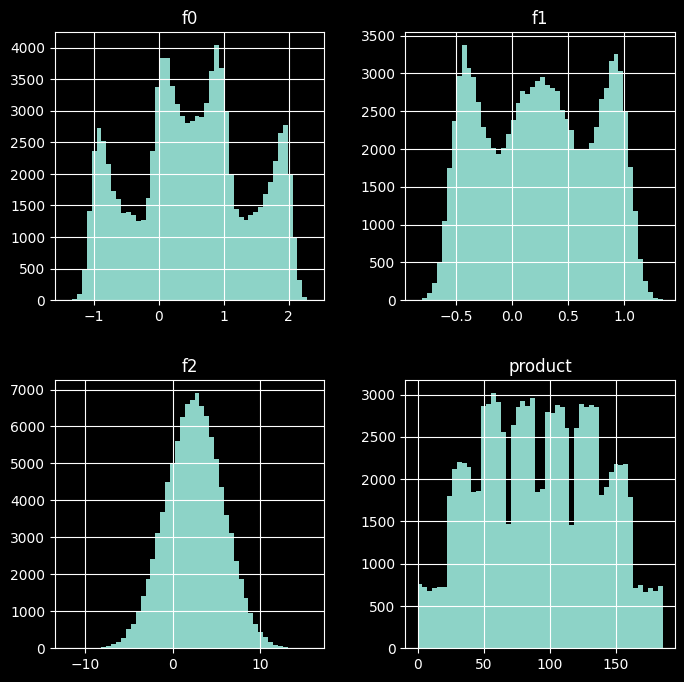

In [14]:
first_view(data_0)

~~~~~~~~~~~~~~~~~~ Обзор данных первых и последних пяти строк ~~~~~~~~~~~~~~~~~~~


,id,f0,f1,f2,product
0,kBEdx,-15.00,-8.28,-0.01,3.18
1,62mP7,14.27,-3.48,1.00,26.95
2,vyE1P,6.26,-5.95,5.00,134.77
3,KcrkZ,-13.08,-11.51,5.00,137.95
4,AHL4O,12.70,-8.15,5.00,134.77


,id,f0,f1,f2,product
99995,QywKC,9.54,-6.88,2.00,53.91
99996,ptvty,-10.16,-12.56,5.01,137.95
99997,09gWa,-7.38,-3.08,5.00,137.95
99998,rqwUm,0.67,-6.15,1.00,30.13
99999,relB0,-3.43,-7.79,-0.00,3.18



~~~~~~~~~~~~~~~~~~~~~~~ Основная описательная статистика ~~~~~~~~~~~~~~~~~~~~~~~~


,f0,f1,f2,product
count,100000.00,100000.00,100000.00,100000.00
mean,1.14,-4.80,2.49,68.83
std,8.97,5.12,1.70,45.94
min,-31.61,-26.36,-0.02,0.00
25%,-6.30,-8.27,1.00,26.95
50%,1.15,-4.81,2.01,57.09
75%,8.62,-1.33,4.00,107.81
max,29.42,18.73,5.02,137.95



~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Тип данных ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Подсчёт пропусков ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
В датафрейме пропуски отсутствуют

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Явные дубликаты ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Явные дубликаты в датасете отсутствуют

~~~~~~~~~~~~~~~~~~~~~~~~ Просмотр гистограмм датафрейма ~~~~~~~~~~~~~~~~~~~~~~~~~


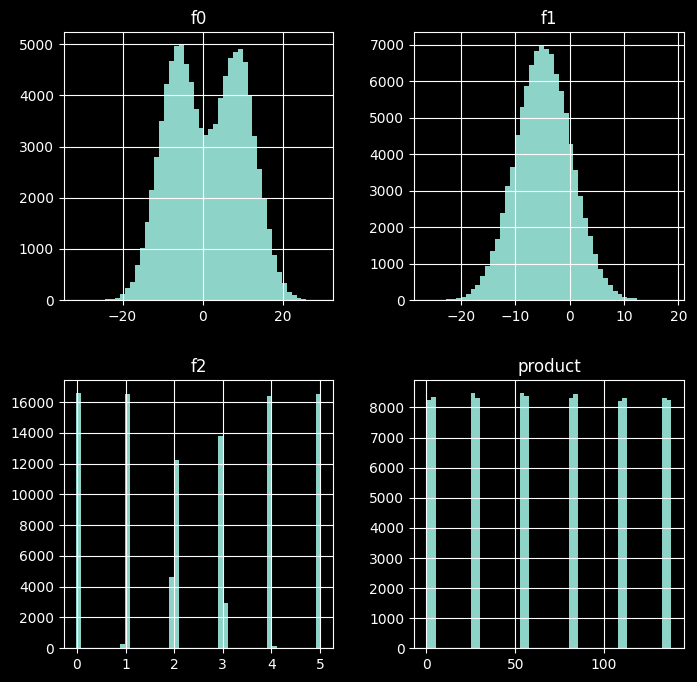

In [15]:
first_view(data_1)

~~~~~~~~~~~~~~~~~~ Обзор данных первых и последних пяти строк ~~~~~~~~~~~~~~~~~~~


,id,f0,f1,f2,product
0,fwXo0,-1.15,0.96,-0.83,27.76
1,WJtFt,0.26,0.27,-2.53,56.07
2,ovLUW,0.19,0.29,-5.59,62.87
3,q6cA6,2.24,-0.55,0.93,114.57
4,WPMUX,-0.52,1.72,5.90,149.60


,id,f0,f1,f2,product
99995,4GxBu,-1.78,1.13,6.26,172.33
99996,YKFjq,-1.26,-0.89,2.52,138.75
99997,tKPY3,-1.20,-2.96,5.22,157.08
99998,nmxp2,-2.42,2.42,-5.55,51.80
99999,V9kWn,-2.55,-2.03,6.09,102.78



~~~~~~~~~~~~~~~~~~~~~~~ Основная описательная статистика ~~~~~~~~~~~~~~~~~~~~~~~~


,f0,f1,f2,product
count,100000.00,100000.00,100000.00,100000.00
mean,0.00,-0.00,2.50,95.00
std,1.73,1.73,3.47,44.75
min,-8.76,-7.08,-11.97,0.00
25%,-1.16,-1.17,0.13,59.45
50%,0.01,-0.01,2.48,94.93
75%,1.16,1.16,4.86,130.60
max,7.24,7.84,16.74,190.03



~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Тип данных ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Подсчёт пропусков ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
В датафрейме пропуски отсутствуют

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Явные дубликаты ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Явные дубликаты в датасете отсутствуют

~~~~~~~~~~~~~~~~~~~~~~~~ Просмотр гистограмм датафрейма ~~~~~~~~~~~~~~~~~~~~~~~~~


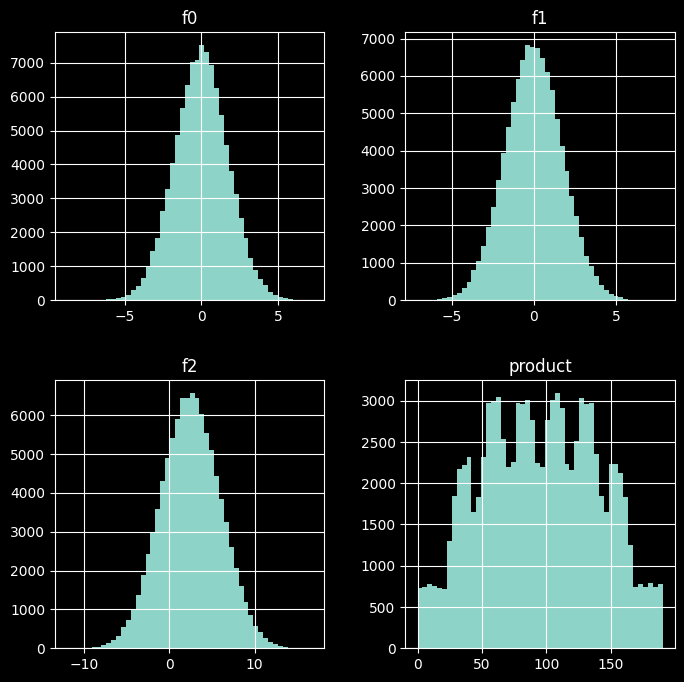

In [16]:
first_view(data_2)

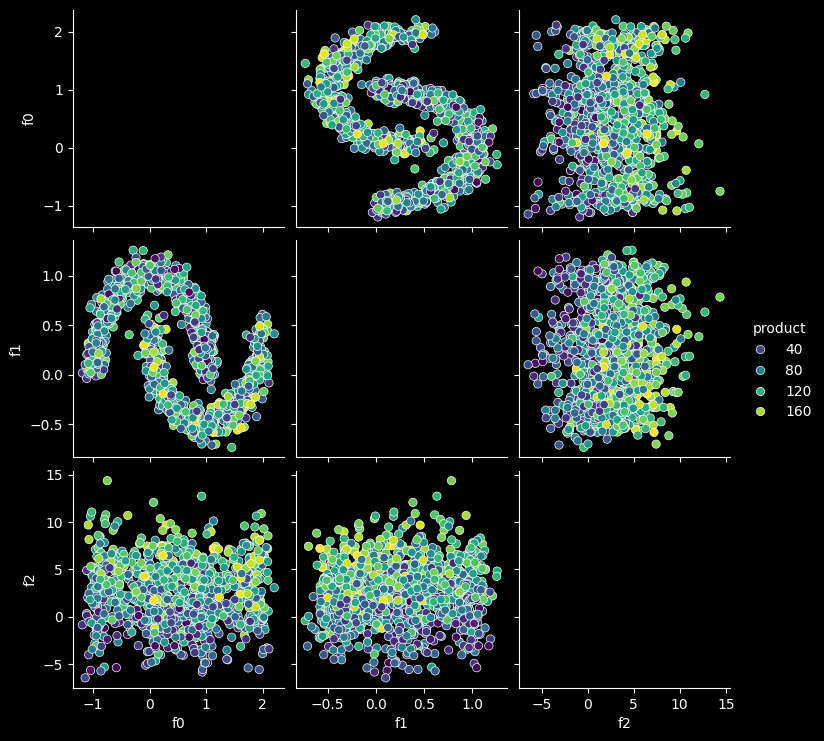

In [17]:
sns.pairplot(data_0.sample(frac=0.01, random_state=1337), hue='product', palette='viridis');

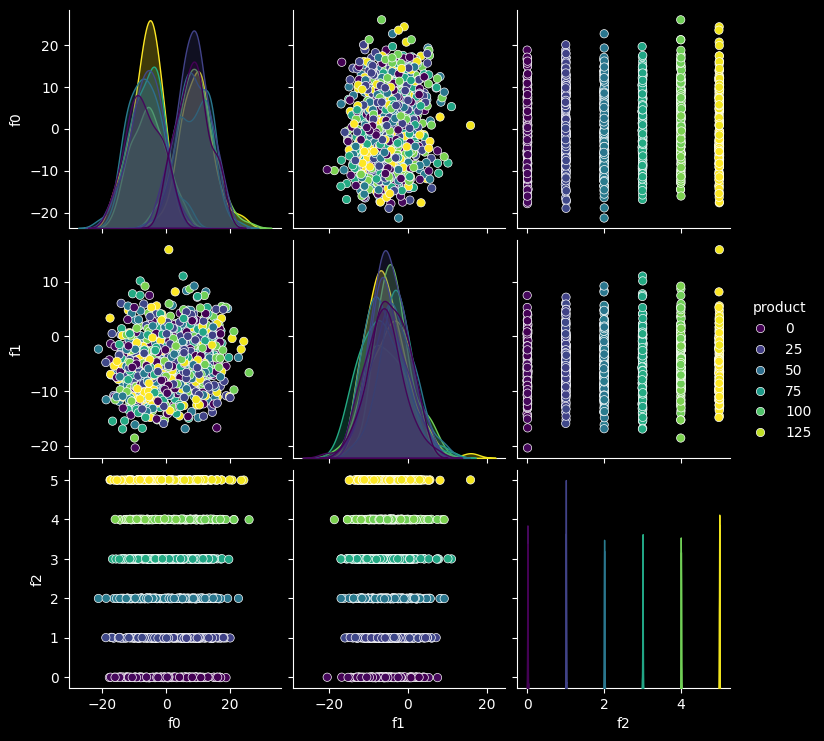

In [18]:
sns.pairplot(data_1.sample(frac=0.01, random_state=1337), hue='product', palette='viridis');

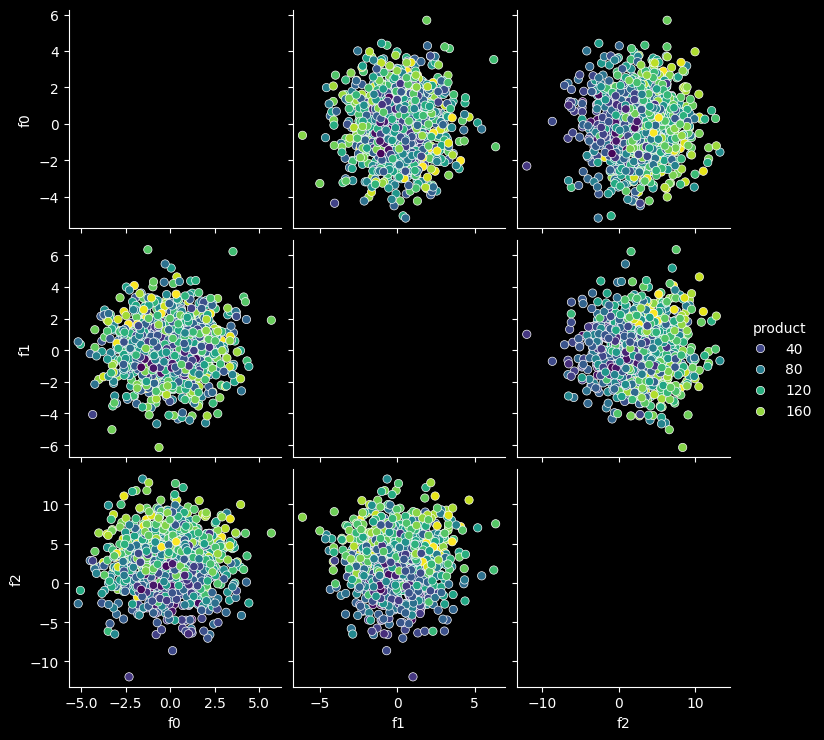

In [19]:
sns.pairplot(data_2.sample(frac=0.01, random_state=1337), hue='product', palette='viridis');

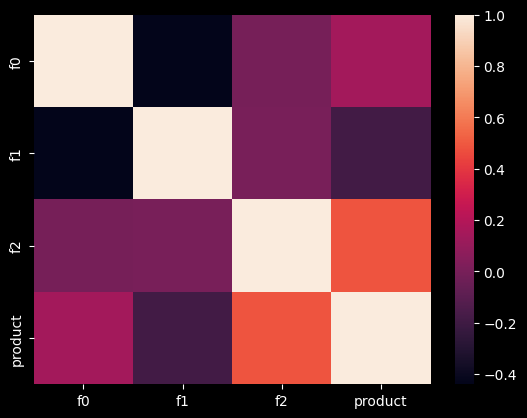

In [20]:
sns.heatmap(data_0.select_dtypes(include=[float, int]).corr());

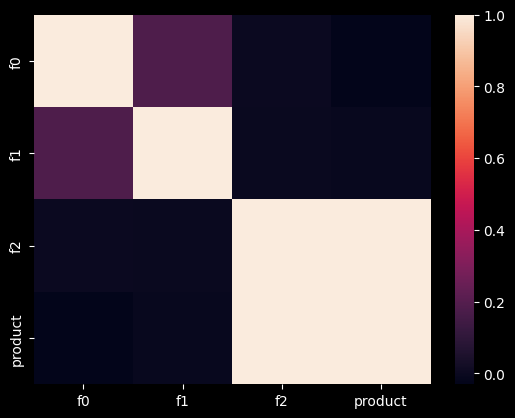

In [21]:
sns.heatmap(data_1.select_dtypes(include=[float, int]).corr());

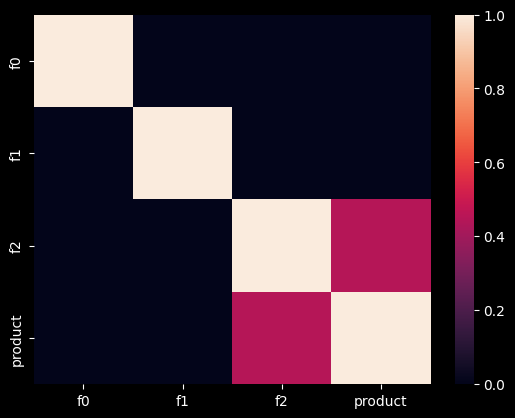

In [22]:
sns.heatmap(data_2.select_dtypes(include=[float, int]).corr());

In [23]:
print('Id первого датасета имеют', data_0['id'].nunique(), 'уникальных значений')
print('Id второго датасета имеют', data_1['id'].nunique(), 'уникальных значений')
print('Id третьего датасета имеют', data_2['id'].nunique(), 'уникальных значений')

Id первого датасета имеют 99990 уникальных значений
Id второго датасета имеют 99996 уникальных значений
Id третьего датасета имеют 99996 уникальных значений


In [24]:
data_0_id_doublicated = data_0['id'].value_counts().head(10).index
data_1_id_doublicated = data_1['id'].value_counts().head(4).index
data_2_id_doublicated = data_2['id'].value_counts().head(4).index

display(data_0.query('id in @data_0_id_doublicated').sort_values(by='id'))
display(data_1.query('id in @data_1_id_doublicated').sort_values(by='id'))
display(data_2.query('id in @data_2_id_doublicated').sort_values(by='id'))

,id,f0,f1,f2,product
66136,74z30,1.08,-0.31,6.99,127.64
64022,74z30,0.74,0.46,5.15,140.77
51970,A5aEY,-0.18,0.94,-2.09,33.02
3389,A5aEY,-0.04,0.16,0.21,89.25
69163,AGS9W,-0.93,0.12,-3.66,19.23
42529,AGS9W,1.45,-0.48,0.68,126.37
931,HZww2,0.76,0.37,1.86,30.68
7530,HZww2,1.06,-0.37,10.43,158.83
63593,QcMuo,0.64,-0.47,0.86,64.58
1949,QcMuo,0.51,-0.32,-2.22,75.50


,id,f0,f1,f2,product
5849,5ltQ6,-3.44,-12.30,2.00,57.09
84461,5ltQ6,18.21,2.19,3.99,107.81
1305,LHZR0,11.17,-1.95,3.00,80.86
41906,LHZR0,-8.99,-4.29,2.01,57.09
2721,bfPNe,-9.49,-5.46,4.01,110.99
82178,bfPNe,-6.20,-4.82,3.00,84.04
47591,wt4Uk,-9.09,-8.11,-0.00,3.18
82873,wt4Uk,10.26,-9.38,4.99,134.77


,id,f0,f1,f2,product
45404,KUPhW,0.23,-1.70,4.99,11.72
55967,KUPhW,1.21,3.18,5.54,132.83
11449,VF7Jo,2.12,-0.86,5.75,181.72
49564,VF7Jo,-0.88,0.56,0.72,136.23
44378,Vcm5J,-1.23,-2.44,1.22,137.97
95090,Vcm5J,2.59,1.99,2.48,92.33
28039,xCHr8,1.63,0.37,-2.38,6.12
43233,xCHr8,-0.85,2.10,5.60,184.39


- Во всех трёх датасетах отсутствуют пропуски и дубликаты.
- Все три датасета содержат по 100000 строк.
- во всех трёх датасетах столбец `product` содержит нулевые значения
- во всех трёх датасетах столбцы `f0`, `f1` и `f2` имеют разное масштабирование, и имеют различные типы распределения, где-то нормальные, где-то нет
- во всех трёх датасетах есть некоторое количество повторяющихся `id` скважин, значения этих строк полностью различны
- фича `f2` сильно коррелирует с целевым параметром

## Обучение и проверка модели

### Разбиение данных на выборки

In [25]:
def split(data):
    x = data.drop(['product', 'id'], axis=1)
    y = data['product']
    x_train, x_valid, y_train, y_valid = train_test_split(
        x, y, test_size=0.25, random_state=1337)
    print('Размер тренировочной выборки:')
    print(f'признаки {x_train.shape};')
    print(f'целевой признак {y_train.shape}')
    print(f'это {round((y_train.count() / y.count()) * 100)}% от датасета')
    print()
    print('Размер валидационной выборки:')
    print(f'признаки {x_valid.shape};')
    print(f'целевой признак {y_valid.shape}')
    print(f'это {round((y_valid.count() / y.count()) * 100)}% от датасета')
    return x_train, x_valid, y_train, y_valid

In [26]:
x_0_train, x_0_valid, y_0_train, y_0_valid = split(data_0)

Размер тренировочной выборки:
признаки (75000, 3);
целевой признак (75000,)
это 75% от датасета

Размер валидационной выборки:
признаки (25000, 3);
целевой признак (25000,)
это 25% от датасета


In [27]:
x_1_train, x_1_valid, y_1_train, y_1_valid = split(data_1)

Размер тренировочной выборки:
признаки (75000, 3);
целевой признак (75000,)
это 75% от датасета

Размер валидационной выборки:
признаки (25000, 3);
целевой признак (25000,)
это 25% от датасета


In [28]:
x_2_train, x_2_valid, y_2_train, y_2_valid = split(data_2)

Размер тренировочной выборки:
признаки (75000, 3);
целевой признак (75000,)
это 75% от датасета

Размер валидационной выборки:
признаки (25000, 3);
целевой признак (25000,)
это 25% от датасета


### Масштабируем данные

In [29]:
numeric = ['f0', 'f1', 'f2']

scaler = StandardScaler()

scaler.fit(x_0_train[numeric])
x_0_train[numeric] = scaler.transform(x_0_train[numeric])
x_0_valid[numeric] = scaler.transform(x_0_valid[numeric])

scaler.fit(x_1_train[numeric])
x_1_train[numeric] = scaler.transform(x_1_train[numeric])
x_1_valid[numeric] = scaler.transform(x_1_valid[numeric])

scaler.fit(x_2_train[numeric])
x_2_train[numeric] = scaler.transform(x_2_train[numeric])
x_2_valid[numeric] = scaler.transform(x_2_valid[numeric])

### Обучим модели и сделаем предсказание на валидационной выборке

In [30]:
def train_model(x_train, x_valid, y_train, y_valid):
    model = LinearRegression().fit(x_train, y_train)
    pred_valid = pd.Series(model.predict(x_valid))
    mse = mean_squared_error(y_valid, pred_valid)
    rmse = math.sqrt(mse)
    print('RMSE модели =', round(rmse, 2))
    print('Средний запас предсказанного сырья =', round(pred_valid.mean(), 2), 'тыс. баррелей')
    return model, pred_valid

In [31]:
model_0, pred_0_valid = train_model(x_0_train, x_0_valid, y_0_train, y_0_valid)

RMSE модели = 37.83
Средний запас предсказанного сырья = 92.42 тыс. баррелей


In [32]:
model_1, pred_1_valid = train_model(x_1_train, x_1_valid, y_1_train, y_1_valid)

RMSE модели = 0.88
Средний запас предсказанного сырья = 68.67 тыс. баррелей


In [33]:
model_2, pred_2_valid = train_model(x_2_train, x_2_valid, y_2_train, y_2_valid)

RMSE модели = 40.22
Средний запас предсказанного сырья = 94.97 тыс. баррелей


### Проанализируем результаты

Самая точная модель получилась на втором регионе, RMSE всего 0.88

Наибольшее количество предсказанного сырья имеет третий регион

## Подготовка к расчёту прибыли

In [34]:
PRICE = 450_000
BUDGET = 10_000_000_000

def profit(pred, y):
    state = np.random.RandomState(1337)
    values = []
    for i in range(1000):
        sub = pred.sample(n=500, replace=True, random_state=state)
        best_200_pred = sub.sort_values(ascending=False)[:200]
        best_200 = y.iloc[best_200_pred.index]
        result = PRICE * best_200.sum() - BUDGET
        values.append(result)

    values = pd.Series(values)

    return values

def risk(profit):
    return len(profit[profit<0])/len(profit)*100

In [35]:
profit_limit = BUDGET / 200 / PRICE

print('Достаточный объём сырья для безубыточной разработки новой скважины', round(profit_limit, 2), 'тыс. баррелей')
print('Средний запас предсказанного сырья первого региона', round(pred_0_valid.mean(), 2), 'тыс. баррелей')
print('Средний запас предсказанного сырья второго региона', round(pred_1_valid.mean(), 2), 'тыс. баррелей')
print('Средний запас предсказанного сырья третьего региона', round(pred_2_valid.mean(), 2), 'тыс. баррелей')

Достаточный объём сырья для безубыточной разработки новой скважины 111.11 тыс. баррелей
Средний запас предсказанного сырья первого региона 92.42 тыс. баррелей
Средний запас предсказанного сырья второго региона 68.67 тыс. баррелей
Средний запас предсказанного сырья третьего региона 94.97 тыс. баррелей


Вывод:

Средний запас сырья не дотягивает до необходимого запаса, который бы приносил прибыль, но это не критично, потому как будет отбиратся 200 лучших скважин, а не средних, то на сколько это будет прибыльно расчитаем далее

## Расчёт прибыли и рисков 

Средняя прибыль первого региона = 368.76 млн.руб.
95%-ый доверительный интервал первого региона = (-138.27 - 866.31) млн.руб.
Риск убытков в первом регионе составляет 8.0%

Средняя прибыль второго региона = 456.17 млн.руб.
95%-ый доверительный интервал второго региона = (29.42 - 859.51) млн.руб.
Риск убытков во втором регионе составляет 2.1%

Средняя прибыль третьего региона = 354.81 млн.руб.
95%-ый доверительный интервал третьего региона = (-200.16 - 864.21) млн.руб.
Риск убытков в третьем регионе составляет 9.6%


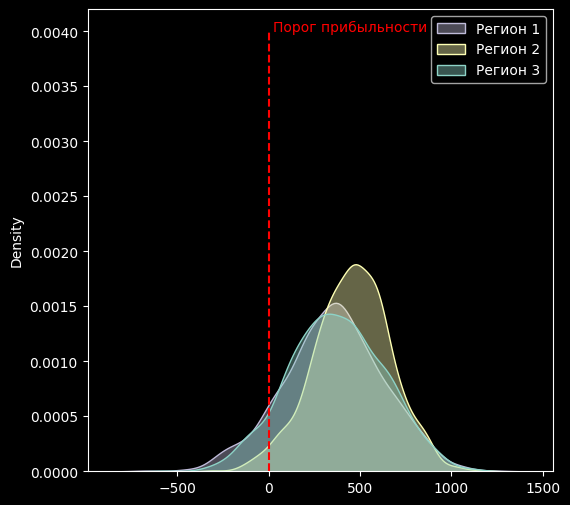

In [36]:
profit_0 = profit(pred_0_valid, y_0_valid)
profit_1 = profit(pred_1_valid, y_1_valid)
profit_2 = profit(pred_2_valid, y_2_valid)

profits = pd.DataFrame({'profit_0': profit_0, 'profit_1': profit_1, 'profit_2': profit_2}) / 1_000_000

conf_0_lo = round(profit_0.quantile(0.025) / 1_000_000, 2)
conf_0_up = round(profit_0.quantile(0.975) / 1_000_000, 2)
conf_1_lo = round(profit_1.quantile(0.025) / 1_000_000, 2)
conf_1_up = round(profit_1.quantile(0.975) / 1_000_000, 2)
conf_2_lo = round(profit_2.quantile(0.025) / 1_000_000, 2)
conf_2_up = round(profit_2.quantile(0.975) / 1_000_000, 2)


print(f'Средняя прибыль первого региона = {round(profit_0.mean()/1_000_000, 2)} млн.руб.')
print(f'95%-ый доверительный интервал первого региона = ({conf_0_lo} - {conf_0_up}) млн.руб.')
print(f'Риск убытков в первом регионе составляет {round(risk(profit_0), 2)}%')
print()
print(f'Средняя прибыль второго региона = {round(profit_1.mean()/1_000_000, 2)} млн.руб.')
print(f'95%-ый доверительный интервал второго региона = ({conf_1_lo} - {conf_1_up}) млн.руб.')
print(f'Риск убытков во втором регионе составляет {round(risk(profit_1), 2)}%')
print()
print(f'Средняя прибыль третьего региона = {round(profit_2.mean()/1_000_000, 2)} млн.руб.')
print(f'95%-ый доверительный интервал третьего региона = ({conf_2_lo} - {conf_2_up}) млн.руб.')
print(f'Риск убытков в третьем регионе составляет {round(risk(profit_2), 2)}%')

fig, ax = plt.subplots(figsize=(6,6))
sns.kdeplot(data=profits, fill=True, common_norm=False, alpha=0.4, ax=ax) 
ax.legend(['Регион 1', 'Регион 2', 'Регион 3'])
ax.vlines(0, 0, 0.004, color = 'r', linestyle = '--')
ax.text(25, 0.004, 'Порог прибыльности', color = 'r')
plt.show()

## Вывод

***
Лишь второй регион соответствует допустимому пределу вероятности рисков в 2.5%

Второй регион имеет наибольшую среднюю прибыль в 456.17 млн рублей

Следовательно можно предложить для разработки этот регион